## Weiss World Hackathon
the goal of this notebook is to create models for predictive maintenance purposes.

In [1]:
# Data Science Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.utils import resample

# ML Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

### Explorative Analysis - plc raw 15m

In [2]:
df = pd.read_csv('plc_raw_15m.csv')

In [3]:
df.head()

,_start,_stop,_time,_value,Device,_field,_measurement,article_no,serial_no
0,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:55.836400+00:00,1015723,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
1,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:56.939900+00:00,1015724,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
2,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:58.041300+00:00,1015725,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
3,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:59.145200+00:00,1015726,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
4,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:51:00.245800+00:00,1015727,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T


What does _start and _stop mean?

In [4]:
df_2 = df.copy()

In [5]:
df_2['_start'] = pd.to_datetime(df_2['_start'])
df_2['_stop'] = pd.to_datetime(df_2['_stop'])

In [6]:
df_2['Time_Difference'] = df_2['_stop'] - df_2['_start']
df_2.head()

,_start,_stop,_time,_value,Device,_field,_measurement,article_no,serial_no,Time_Difference
0,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:55.836400+00:00,1015723,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T,0 days 00:15:00
1,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:56.939900+00:00,1015724,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T,0 days 00:15:00
2,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:58.041300+00:00,1015725,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T,0 days 00:15:00
3,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:50:59.145200+00:00,1015726,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T,0 days 00:15:00
4,2023-09-19 15:50:55.623565+00:00,2023-09-19 16:05:55.623565+00:00,2023-09-19 15:51:00.245800+00:00,1015727,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T,0 days 00:15:00


_start and _stop just give you the beginning and the end of the time range that you queried. In this case I queried for 15 min, so the difference will always be 15 mins for every row

Is it always the same value for the columns serial_no, article_no, measurement, device and field?

In [7]:
print("serial_no:", df_2['serial_no'].unique())
print("article_no:", df_2['article_no'].unique())
print("measurement:", df_2['_measurement'].unique())
print("Device:", df_2['Device'].unique())
print("field:", df_2['_field'].unique())

serial_no: ['TC150T']
article_no: ['TC260K-8-D']
measurement: ['EF3']
Device: ['EF3_010.001.070.005']
field: ['CycleCount' 'CycleTimeSensorLowToSensorHigh'
 'CycleTimeStartHighToInOperationLow' 'CycleTimeStartHighToSensorHigh'
 'During_Cycle_Current[A]' 'During_Cycle_Time[sec]' 'MaxLastCycle'
 'RmsLastCycle' 'TimeStamp' 'WhoAmI']


field is important, since it gives the background info to the data

In [8]:
df_2_important_cols = df_2[["_time", "_value", "_field"]]

In [9]:
df_2_important_cols

,_time,_value,_field
0,2023-09-19 15:50:55.836400+00:00,1015723,CycleCount
1,2023-09-19 15:50:56.939900+00:00,1015724,CycleCount
2,2023-09-19 15:50:58.041300+00:00,1015725,CycleCount
3,2023-09-19 15:50:59.145200+00:00,1015726,CycleCount
4,2023-09-19 15:51:00.245800+00:00,1015727,CycleCount
...,...,...,...
5993,2023-09-19 16:04:52.789900+00:00,Hello here is the EF3 via mqtt,WhoAmI
5994,2023-09-19 16:05:02.794200+00:00,Hello here is the EF3 via mqtt,WhoAmI
5995,2023-09-19 16:05:12.789200+00:00,Hello here is the EF3 via mqtt,WhoAmI
5996,2023-09-19 16:05:22.796500+00:00,Hello here is the EF3 via mqtt,WhoAmI


Data with WhoAmI can be removed since its always from the same machine

In [10]:
# 1. step - remove unncessary value
df_cleaned = df_2_important_cols[df_2_important_cols['_field'] != 'WhoAmI']

In [11]:
df_cleaned

,_time,_value,_field
0,2023-09-19 15:50:55.836400+00:00,1015723,CycleCount
1,2023-09-19 15:50:56.939900+00:00,1015724,CycleCount
2,2023-09-19 15:50:58.041300+00:00,1015725,CycleCount
3,2023-09-19 15:50:59.145200+00:00,1015726,CycleCount
4,2023-09-19 15:51:00.245800+00:00,1015727,CycleCount
...,...,...,...
5950,2023-09-19 16:05:48.810100+00:00,47006664191,TimeStamp
5951,2023-09-19 16:05:49.912200+00:00,47006665294,TimeStamp
5952,2023-09-19 16:05:51.027700+00:00,47006666396,TimeStamp
5953,2023-09-19 16:05:52.174100+00:00,47006667498,TimeStamp


hmm are there multiple rows with the same timestamp? Let check it with the third timestamp

In [12]:
third_row_timestamp = df_cleaned.loc[3, '_time']
third_row_timestamp

'2023-09-19 15:50:59.145200+00:00'

In [13]:
df_3_timestamp = df_cleaned[df_cleaned['_time'] == third_row_timestamp]
df_3_timestamp

,_time,_value,_field
3,2023-09-19 15:50:59.145200+00:00,1015726,CycleCount
818,2023-09-19 15:50:59.145200+00:00,368,CycleTimeSensorLowToSensorHigh
1633,2023-09-19 15:50:59.145200+00:00,598,CycleTimeStartHighToInOperationLow
2448,2023-09-19 15:50:59.145200+00:00,481,CycleTimeStartHighToSensorHigh
3427,2023-09-19 15:50:59.145200+00:00,0.56,MaxLastCycle
4242,2023-09-19 15:50:59.145200+00:00,0.36,RmsLastCycle
5057,2023-09-19 15:50:59.145200+00:00,47005774523,TimeStamp


yes there are! So it would be better to have for each field their own column. We will pivot the dataframe

In [14]:
# 2. step - pivot dataframe
pivoted_df = df_cleaned.pivot(index='_time', columns='_field', values='_value').reset_index()

In [15]:
pivoted_df

_field,_time,CycleCount,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,During_Cycle_Current[A],During_Cycle_Time[sec],MaxLastCycle,RmsLastCycle,TimeStamp
0,2023-09-19 15:50:55.836400+00:00,1015723,369,599,482,NaN,NaN,0.56,0.36,47005771216
1,2023-09-19 15:50:56.939900+00:00,1015724,369,598,481,NaN,NaN,0.56,0.36,47005772318
2,2023-09-19 15:50:58.041300+00:00,1015725,368,599,482,NaN,NaN,0.57,0.36,47005773421
3,2023-09-19 15:50:59.145200+00:00,1015726,368,598,481,NaN,NaN,0.56,0.36,47005774523
4,2023-09-19 15:51:00.245800+00:00,1015727,368,598,481,NaN,NaN,0.56,0.36,47005775625
...,...,...,...,...,...,...,...,...,...,...
896,2023-09-19 16:05:48.810100+00:00,1016533,368,599,482,NaN,NaN,0.57,0.36,47006664191
897,2023-09-19 16:05:49.912200+00:00,1016534,369,599,482,NaN,NaN,0.56,0.36,47006665294
898,2023-09-19 16:05:51.027700+00:00,1016535,368,598,481,NaN,NaN,0.56,0.36,47006666396
899,2023-09-19 16:05:52.174100+00:00,1016536,368,598,481,0.01|0.01|0.01|0.01|0.02|0.04|0.05|0.07|0.09|...,0|1|1002|3|4|5|6|7|8|9|10|11|12|13|14|15|16|1...,0.56,0.36,47006667498


There are 900 values for 15 minutes => Per second, 1 row

Is the data type of _time column already a timestamp?

In [16]:
print(pivoted_df.dtypes)

_field
_time                                 object
CycleCount                            object
CycleTimeSensorLowToSensorHigh        object
CycleTimeStartHighToInOperationLow    object
CycleTimeStartHighToSensorHigh        object
During_Cycle_Current[A]               object
During_Cycle_Time[sec]                object
MaxLastCycle                          object
RmsLastCycle                          object
TimeStamp                             object
dtype: object


everything is an object so I need to turn _time to datetype

In [17]:
df_time = pivoted_df.copy()

In [18]:
# Convert time data type to Timestamp
df_time['_time'] = pd.to_datetime(df_time['_time'])

# Convert the 'CycleTimeSensorLowToSensorHigh' column to numeric
df_time['CycleTimeSensorLowToSensorHigh'] = pd.to_numeric(df_time['CycleTimeSensorLowToSensorHigh'], errors='coerce')
df_time['CycleTimeStartHighToInOperationLow'] = pd.to_numeric(df_time['CycleTimeStartHighToInOperationLow'], errors='coerce')
df_time['CycleTimeStartHighToSensorHigh'] = pd.to_numeric(df_time['CycleTimeStartHighToSensorHigh'], errors='coerce')
df_time['MaxLastCycle'] = pd.to_numeric(df_time['MaxLastCycle'], errors='coerce')
df_time['RmsLastCycle'] = pd.to_numeric(df_time['RmsLastCycle'], errors='coerce')

In [19]:
df_time.dtypes

_field
_time                                 datetime64[ns, UTC]
CycleCount                                         object
CycleTimeSensorLowToSensorHigh                    float64
CycleTimeStartHighToInOperationLow                float64
CycleTimeStartHighToSensorHigh                    float64
During_Cycle_Current[A]                            object
During_Cycle_Time[sec]                             object
MaxLastCycle                                      float64
RmsLastCycle                                      float64
TimeStamp                                          object
dtype: object

Visualize the data for CycleTimeSensorLowToSensorHigh

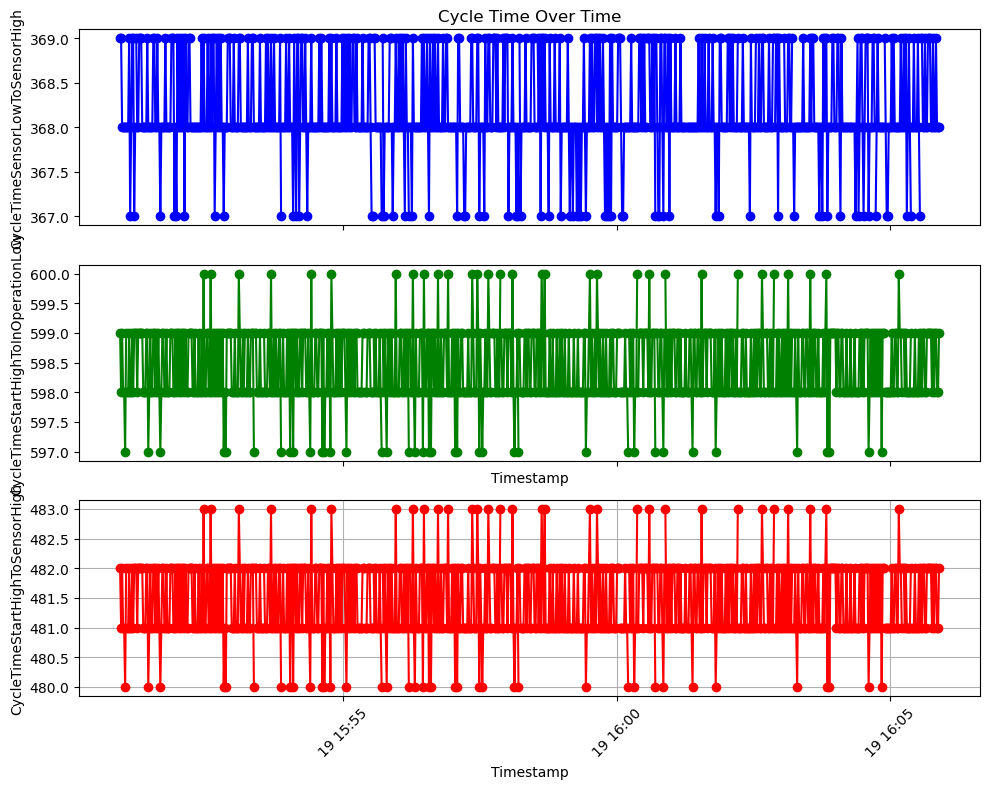

In [20]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)  # Adjust the figure size as needed


# Plot 'CycleTimeSensorLowToSensorHigh' in the first subplot (ax1)
ax1.plot(df_time['_time'], df_time['CycleTimeSensorLowToSensorHigh'], marker='o', linestyle='-', color='b')
ax1.set_ylabel('CycleTimeSensorLowToSensorHigh')
ax1.set_title('Cycle Time Over Time')

# Plot 'CycleTimeStartHighToInOperationLow' in the second subplot (ax2)
ax2.plot(df_time['_time'], df_time['CycleTimeStartHighToInOperationLow'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('CycleTimeStartHighToInOperationLow')

# Plot 'CycleTimeStartHighToSensorHigh' in the third subplot (ax3)
ax3.plot(df_time['_time'], df_time['CycleTimeStartHighToSensorHigh'], marker='o', linestyle='-', color='r')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('CycleTimeStartHighToSensorHigh')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Just from the visualization **CycleTimeStartHighToSensorHigh** and **CycleTimeStartHighToInOperationLow** correlate with each other

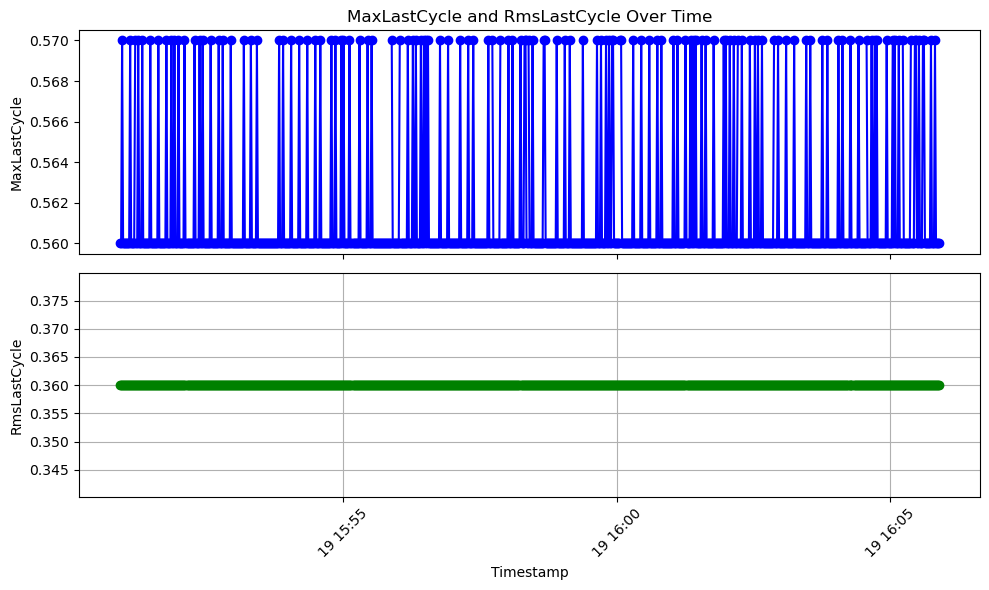

In [21]:
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 'MaxLastCycle' in the first subplot (ax1)
ax1.plot(df_time['_time'], df_time['MaxLastCycle'], marker='o', linestyle='-', color='b')
ax1.set_ylabel('MaxLastCycle')
ax1.set_title('MaxLastCycle and RmsLastCycle Over Time')

# Plot 'RmsLastCycle' in the second subplot (ax2)
ax2.plot(df_time['_time'], df_time['RmsLastCycle'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('RmsLastCycle')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### Create an Isolation Forest model to test how it functions
For that I create a new column and label every row where CycleTimeStartHighToSensorHigh is out of 481 - 482 range

In [22]:
# Find unique values
# 481 & 482 are normal values
unique_values = df_time['CycleTimeStartHighToSensorHigh'].unique()
unique_values

array([482., 481., 480.,  nan, 483.])

In [23]:
# Create a new column 'anomaly' with initial value 0
df_time['anomaly'] = 0

# Assign the value 1 to rows where 'CycleTimeStartHighToSensorHigh' is not 481 or 482
df_time.loc[~df_time['CycleTimeStartHighToSensorHigh'].isin([481, 482]), 'anomaly'] = 1

In [24]:
df_time.head()

_field,_time,CycleCount,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,During_Cycle_Current[A],During_Cycle_Time[sec],MaxLastCycle,RmsLastCycle,TimeStamp,anomaly
0,2023-09-19 15:50:55.836400+00:00,1015723,369.0,599.0,482.0,NaN,NaN,0.56,0.36,47005771216,0
1,2023-09-19 15:50:56.939900+00:00,1015724,369.0,598.0,481.0,NaN,NaN,0.56,0.36,47005772318,0
2,2023-09-19 15:50:58.041300+00:00,1015725,368.0,599.0,482.0,NaN,NaN,0.57,0.36,47005773421,0
3,2023-09-19 15:50:59.145200+00:00,1015726,368.0,598.0,481.0,NaN,NaN,0.56,0.36,47005774523,0
4,2023-09-19 15:51:00.245800+00:00,1015727,368.0,598.0,481.0,NaN,NaN,0.56,0.36,47005775625,0


In [25]:
nan_counts = df_time.isna().sum()
print(nan_counts)

_field
_time                                   0
CycleCount                             86
CycleTimeSensorLowToSensorHigh         86
CycleTimeStartHighToInOperationLow     86
CycleTimeStartHighToSensorHigh         86
During_Cycle_Current[A]               819
During_Cycle_Time[sec]                819
MaxLastCycle                           86
RmsLastCycle                           86
TimeStamp                               0
anomaly                                 0
dtype: int64


There are NaN values in CycleCount. Let try to visualize it to check if there is a pattern

In [26]:
# Get a DataFrame with all rows where 'CycleCount' is NaN
nan_rows = df_time[df_time['CycleCount'].isna()]

# Print the DataFrame
print("Rows with NaN in 'CycleCount':")
nan_rows.head(20)

Rows with NaN in 'CycleCount':


_field,_time,CycleCount,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,During_Cycle_Current[A],During_Cycle_Time[sec],MaxLastCycle,RmsLastCycle,TimeStamp,anomaly
7,2023-09-19 15:51:02.663800+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005778055,1
8,2023-09-19 15:51:02.712200+00:00,NaN,NaN,NaN,NaN,0.01|0.01|0.01|0.01|0.02|0.03|0.05|0.07|0.09|...,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|1...,NaN,NaN,47005778057,1
18,2023-09-19 15:51:12.663600+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005788056,1
19,2023-09-19 15:51:12.719600+00:00,NaN,NaN,NaN,NaN,0.01|0.01|0.01|0.01|0.02|0.04|0.06|0.07|0.09|...,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|1...,NaN,NaN,47005788058,1
29,2023-09-19 15:51:22.664200+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005798057,1
30,2023-09-19 15:51:22.710900+00:00,NaN,NaN,NaN,NaN,0.01|0.01|0.01|0.01|0.02|0.03|0.05|0.07|0.09|...,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|1...,NaN,NaN,47005798059,1
40,2023-09-19 15:51:32.666400+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005808058,1
41,2023-09-19 15:51:32.714500+00:00,NaN,NaN,NaN,NaN,0.01|0.01|0.01|0.01|0.02|0.04|0.05|0.07|0.09|...,0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|1...,NaN,NaN,47005808060,1
124,2023-09-19 15:53:02.702700+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005898067,1
125,2023-09-19 15:53:02.704000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47005898069,1


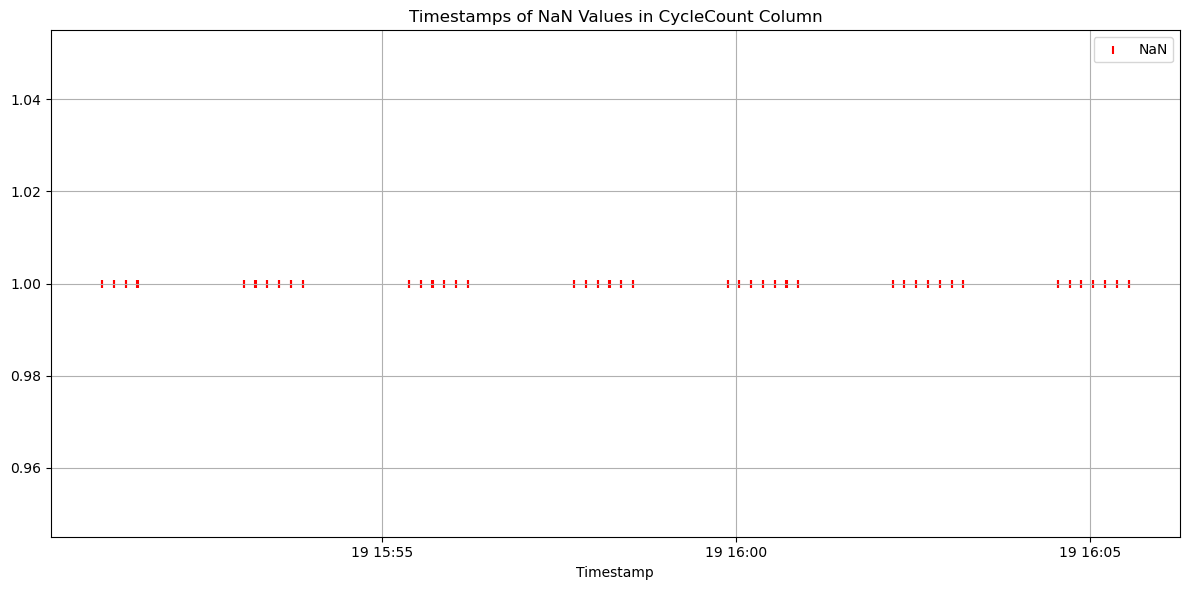

In [27]:
nan_rows = df_time[df_time['CycleCount'].isna()]

# Extract the timestamps for rows with NaN values
nan_timestamps = nan_rows['_time']

# Plot a graph to visualize the timestamps of NaN values
plt.figure(figsize=(12, 6))
plt.scatter(nan_timestamps, [1] * len(nan_timestamps), marker='|', color='r', label='NaN')
plt.xlabel('Timestamp')
plt.title('Timestamps of NaN Values in CycleCount Column')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There is a pattern so it's normal. Let try remove it then

In [28]:
df_time_no_na = df_time.dropna(subset=['CycleCount']).reset_index(drop=True)

In [29]:
df_time_no_na

_field,_time,CycleCount,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,During_Cycle_Current[A],During_Cycle_Time[sec],MaxLastCycle,RmsLastCycle,TimeStamp,anomaly
0,2023-09-19 15:50:55.836400+00:00,1015723,369.0,599.0,482.0,NaN,NaN,0.56,0.36,47005771216,0
1,2023-09-19 15:50:56.939900+00:00,1015724,369.0,598.0,481.0,NaN,NaN,0.56,0.36,47005772318,0
2,2023-09-19 15:50:58.041300+00:00,1015725,368.0,599.0,482.0,NaN,NaN,0.57,0.36,47005773421,0
3,2023-09-19 15:50:59.145200+00:00,1015726,368.0,598.0,481.0,NaN,NaN,0.56,0.36,47005774523,0
4,2023-09-19 15:51:00.245800+00:00,1015727,368.0,598.0,481.0,NaN,NaN,0.56,0.36,47005775625,0
...,...,...,...,...,...,...,...,...,...,...,...
810,2023-09-19 16:05:48.810100+00:00,1016533,368.0,599.0,482.0,NaN,NaN,0.57,0.36,47006664191,0
811,2023-09-19 16:05:49.912200+00:00,1016534,369.0,599.0,482.0,NaN,NaN,0.56,0.36,47006665294,0
812,2023-09-19 16:05:51.027700+00:00,1016535,368.0,598.0,481.0,NaN,NaN,0.56,0.36,47006666396,0
813,2023-09-19 16:05:52.174100+00:00,1016536,368.0,598.0,481.0,0.01|0.01|0.01|0.01|0.02|0.04|0.05|0.07|0.09|...,0|1|1002|3|4|5|6|7|8|9|10|11|12|13|14|15|16|1...,0.56,0.36,47006667498,0


Actual part where you create an y-column

In [30]:
df_time['anomaly'].value_counts()

0    745
1    156
Name: anomaly, dtype: int64

In [31]:
# count values to check if it actually works
df_time_no_na['anomaly'].value_counts()

0    745
1     70
Name: anomaly, dtype: int64

In [32]:
y = df_time_no_na["anomaly"]

columns_to_drop = ['_time', 'anomaly', 'During_Cycle_Current[A]', 'During_Cycle_Time[sec]']
X = df_time_no_na.drop(columns_to_drop, axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
model = IsolationForest(random_state=42)

In [35]:
model.fit(X_train, y_train)

IsolationForest(random_state=42)

In [36]:
y_pred = model.predict(X_test)

In [37]:
y_pred

array([ 1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,
       -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,  1,
       -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1,  1,
        1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1])

the inliers are assigned a ground truth label 1 whereas the outliers are assigned the label -1. To we need to turn 1 -> 0 and -1 -> 1

In [38]:
y_pred_modified = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))

In [39]:
y_pred_modified

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1])

In [40]:
confusion_matrix(y_test, y_pred_modified)

array([[132,  52],
       [  0,  20]], dtype=int64)

TP FP 
<br>FN TN
<br>FP (52) means that there is no anormalies but the system shows that there is anormalies. The system has a really **high variance** 

In [41]:
print("accuracy %s" % accuracy_score(y_pred_modified, y_test))

accuracy 0.7450980392156863


#### Let try Local Outlier Factor
source: https://www.kaggle.com/code/medaziztousli/anomaly-detection-models-for-iot-data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
LOF = LocalOutlierFactor(n_neighbors=20, contamination=.01)

In [51]:
LOF.fit(X_train, y_train)

LocalOutlierFactor(contamination=0.01)

In [52]:
y_pred = LOF.fit_predict(X_test)

In [53]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [56]:
LOF_y_pred = np.where(y_pred == 1, 0, np.where(y_pred == -1, 1, y_pred))

In [58]:
LOF_y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [60]:
confusion_matrix(y_test, y_pred_modified)

array([[132,  52],
       [  0,  20]], dtype=int64)

In [68]:
print("accuracy %s" % accuracy_score(LOF_y_pred, y_test))

accuracy 0.8872549019607843


Accuracy of 88% seems good. Let try to apply hyperparameter tuning

### plc_dS 24h

In [2]:
df_plc_dS_24h = pd.read_csv('plc_dS_24h.csv')

In [3]:
df_plc_dS_24h

,_start,_stop,_time,_value,Device,_field,_measurement,article_no,serial_no
0,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 08:00:00+00:00,5.122237e+02,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T
1,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 08:30:00+00:00,5.122732e+02,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T
2,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 09:00:00+00:00,5.122601e+02,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T
3,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 09:30:00+00:00,5.122322e+02,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T
4,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 10:00:00+00:00,5.121480e+02,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T
...,...,...,...,...,...,...,...,...,...
91,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 13:30:00+00:00,4.699642e+10,EF3_010.001.070.005,TimeStamp,EF3,TC260K-8-D,TC150T
92,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 14:00:00+00:00,4.699821e+10,EF3_010.001.070.005,TimeStamp,EF3,TC260K-8-D,TC150T
93,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 14:30:00+00:00,4.700001e+10,EF3_010.001.070.005,TimeStamp,EF3,TC260K-8-D,TC150T
94,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 15:00:00+00:00,4.700185e+10,EF3_010.001.070.005,TimeStamp,EF3,TC260K-8-D,TC150T


In [4]:
df_plc_dS_24h['_start'] = pd.to_datetime(df_plc_dS_24h['_start'])
df_plc_dS_24h['_stop'] = pd.to_datetime(df_plc_dS_24h['_stop'])

df_plc_dS_24h['Time_Difference'] = df_plc_dS_24h['_stop'] - df_plc_dS_24h['_start']
df_plc_dS_24h.head()

,_start,_stop,_time,_value,Device,_field,_measurement,article_no,serial_no,Time_Difference
0,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 08:00:00+00:00,512.223711,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T,1 days
1,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 08:30:00+00:00,512.273185,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T,1 days
2,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 09:00:00+00:00,512.260057,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T,1 days
3,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 09:30:00+00:00,512.232207,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T,1 days
4,2023-09-18 15:57:06.775518+00:00,2023-09-19 15:57:06.775518+00:00,2023-09-19 10:00:00+00:00,512.147989,EF3_010.001.070.005,CycleTimeSensorLowToSensorHigh,EF3,TC260K-8-D,TC150T,1 days


In [5]:
df_plc_dS_cols = df_plc_dS_24h[["_time", "_value", "_field"]]
df_plc_dS_cols.head()

,_time,_value,_field
0,2023-09-19 08:00:00+00:00,512.223711,CycleTimeSensorLowToSensorHigh
1,2023-09-19 08:30:00+00:00,512.273185,CycleTimeSensorLowToSensorHigh
2,2023-09-19 09:00:00+00:00,512.260057,CycleTimeSensorLowToSensorHigh
3,2023-09-19 09:30:00+00:00,512.232207,CycleTimeSensorLowToSensorHigh
4,2023-09-19 10:00:00+00:00,512.147989,CycleTimeSensorLowToSensorHigh


In [6]:
print("field:", df_plc_dS_cols['_field'].unique())

field: ['CycleTimeSensorLowToSensorHigh' 'CycleTimeStartHighToInOperationLow'
 'CycleTimeStartHighToSensorHigh' 'MaxLastCycle' 'RmsLastCycle'
 'TimeStamp']


In [7]:
pivoted_df_plc_dS = df_plc_dS_cols.pivot(index='_time', columns='_field', values='_value').reset_index()

In [8]:
pivoted_df_plc_dS

_field,_time,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,MaxLastCycle,RmsLastCycle,TimeStamp
0,2023-09-19 08:00:00+00:00,512.223711,789.536082,672.536082,0.492041,0.340000,4.693286e+10
1,2023-09-19 08:30:00+00:00,512.273185,789.584472,672.584472,0.492617,0.340000,4.697842e+10
2,2023-09-19 09:00:00+00:00,512.260057,789.473420,672.473420,0.491947,0.340000,4.698021e+10
3,2023-09-19 09:30:00+00:00,512.232207,789.501078,672.501078,0.491538,0.340000,4.698201e+10
4,2023-09-19 10:00:00+00:00,512.147989,789.454741,672.454741,0.491034,0.340000,4.698381e+10
5,2023-09-19 10:30:00+00:00,512.162356,789.444684,672.444684,0.490812,0.340000,4.698561e+10
6,2023-09-19 11:00:00+00:00,512.363048,789.565061,672.565061,0.490575,0.340000,4.698741e+10
7,2023-09-19 11:30:00+00:00,512.265086,789.525144,672.525144,0.490338,0.340000,4.698921e+10
8,2023-09-19 12:00:00+00:00,512.242272,789.531272,672.531272,0.490259,0.340000,4.699101e+10
9,2023-09-19 12:30:00+00:00,512.091236,789.473420,672.473420,0.490086,0.340000,4.699282e+10


In [9]:
std_deviation = pivoted_df_plc_dS["CycleTimeStartHighToInOperationLow"].std()

In [10]:
std_deviation

53.81120561746507

In [11]:
threshold = 2  # You can adjust this threshold as needed
outliers = pivoted_df_plc_dS[(pivoted_df_plc_dS['CycleTimeStartHighToInOperationLow'] - pivoted_df_plc_dS['CycleTimeStartHighToInOperationLow'].mean()).abs() > threshold * std_deviation]

In [12]:
outliers

_field,_time,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,MaxLastCycle,RmsLastCycle,TimeStamp
15,2023-09-19 15:30:00+00:00,368.293505,598.48223,481.48223,0.561422,0.36,4.700362e+10


In [13]:
std_deviation = pivoted_df_plc_dS["RmsLastCycle"].std()

In [14]:
std_deviation

0.0056343055686922236

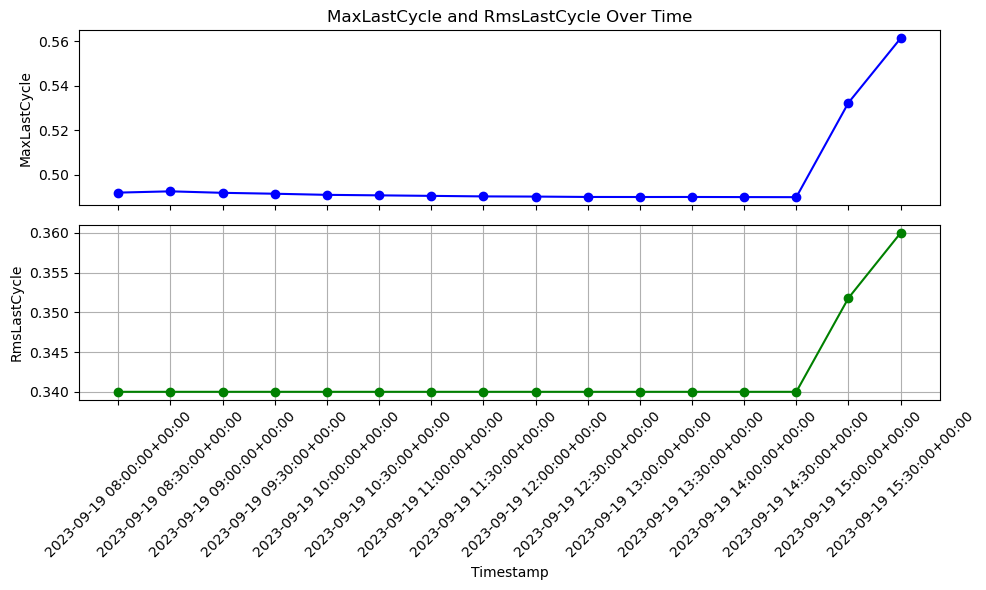

In [84]:
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 'MaxLastCycle' in the first subplot (ax1)
ax1.plot(pivoted_df_plc_dS['_time'], pivoted_df_plc_dS['MaxLastCycle'], marker='o', linestyle='-', color='b')
ax1.set_ylabel('MaxLastCycle')
ax1.set_title('MaxLastCycle and RmsLastCycle Over Time')

# Plot 'RmsLastCycle' in the second subplot (ax2)
ax2.plot(pivoted_df_plc_dS['_time'], pivoted_df_plc_dS['RmsLastCycle'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('RmsLastCycle')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

What does the aggregated data do? Why do you aggregate in half hour cycle?

### plC_raw_48h Calculate the mean length and energy for a cycle

In [4]:
df_plc_48 = pd.read_csv('plc_raw_48h.csv')

C:\Users\Viet Duc Kieu\AppData\Local\Temp\ipykernel_17548\2395860826.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_plc_48 = pd.read_csv('plc_raw_48h.csv')


In [5]:
df_plc_48

,_start,_stop,_time,_value,Device,_field,_measurement,article_no,serial_no
0,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-19 07:39:05.459400+00:00,BG056L4,EF3_010.001.070.005,ConnectedMotor,EF3,TC260K-8-D,TC150T
1,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-19 07:39:06.155000+00:00,992386,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
2,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-19 07:39:07.454100+00:00,992387,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
3,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-19 07:39:08.741600+00:00,992388,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
4,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-19 07:39:10.006400+00:00,992389,EF3_010.001.070.005,CycleCount,EF3,TC260K-8-D,TC150T
...,...,...,...,...,...,...,...,...,...
441670,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-20 05:18:47.459400+00:00,Hello here is the EF3 via mqtt,EF3_010.001.070.005,WhoAmI,EF3,TC260K-8-D,TC150T
441671,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-20 05:19:17.434900+00:00,Hello here is the EF3 via mqtt,EF3_010.001.070.005,WhoAmI,EF3,TC260K-8-D,TC150T
441672,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-20 05:19:37.475000+00:00,Hello here is the EF3 via mqtt,EF3_010.001.070.005,WhoAmI,EF3,TC260K-8-D,TC150T
441673,2023-09-18 12:32:34.412261+00:00,2023-09-20 12:32:34.412261+00:00,2023-09-20 05:20:07.476100+00:00,Hello here is the EF3 via mqtt,EF3_010.001.070.005,WhoAmI,EF3,TC260K-8-D,TC150T


In [6]:
df_plc_48_important_cols = df_plc_48[["_time", "_value", "_field"]]

In [7]:
df_plc_48_important_cols.head()

,_time,_value,_field
0,2023-09-19 07:39:05.459400+00:00,BG056L4,ConnectedMotor
1,2023-09-19 07:39:06.155000+00:00,992386,CycleCount
2,2023-09-19 07:39:07.454100+00:00,992387,CycleCount
3,2023-09-19 07:39:08.741600+00:00,992388,CycleCount
4,2023-09-19 07:39:10.006400+00:00,992389,CycleCount


In [8]:
print("field:", df_plc_48_important_cols['_field'].unique())

field: ['ConnectedMotor' 'CycleCount' 'CycleTimeSensorLowToSensorHigh'
 'CycleTimeStartHighToInOperationLow' 'CycleTimeStartHighToSensorHigh'
 'DeviceType' 'During_Cycle_Current[A]' 'During_Cycle_Time[sec]'
 'MainsRatedVoltage' 'Manufacturer' 'MaxLastCycle' 'RmsLastCycle'
 'SerialNumber' 'TimeStamp' 'WhoAmI']


In [9]:
pivoted_df_plc_48 = df_plc_48_important_cols.pivot(index='_time', columns='_field', values='_value').reset_index()

In [10]:
pivoted_df_plc_48.head()

_field,_time,ConnectedMotor,CycleCount,CycleTimeSensorLowToSensorHigh,CycleTimeStartHighToInOperationLow,CycleTimeStartHighToSensorHigh,DeviceType,During_Cycle_Current[A],During_Cycle_Time[sec],MainsRatedVoltage,Manufacturer,MaxLastCycle,RmsLastCycle,SerialNumber,TimeStamp,WhoAmI
0,2023-09-19 07:39:05.459400+00:00,BG056L4,NaN,NaN,NaN,NaN,TC0150T,NaN,NaN,400 Veff,WEISS Group,NaN,NaN,1356824509185503002624.0,0.0,NaN
1,2023-09-19 07:39:06.155000+00:00,NaN,992386,511,789,672,NaN,NaN,NaN,NaN,NaN,0.49,0.34,NaN,46976261444.0,NaN
2,2023-09-19 07:39:07.454100+00:00,NaN,992387,512,789,672,NaN,NaN,NaN,NaN,NaN,0.5,0.34,NaN,46976262737.0,NaN
3,2023-09-19 07:39:08.741600+00:00,NaN,992388,512,789,672,NaN,NaN,NaN,NaN,NaN,0.49,0.34,NaN,46976264030.0,NaN
4,2023-09-19 07:39:10.006400+00:00,NaN,992389,513,791,674,NaN,NaN,NaN,NaN,NaN,0.5,0.34,NaN,46976265325.0,NaN


In [11]:
print("field:", pivoted_df_plc_48['ConnectedMotor'].unique())

field: ['BG056L4' nan]


In [12]:
df_plc_48_selected_cols = pivoted_df_plc_48[["_time", "CycleCount", "CycleTimeStartHighToInOperationLow", 
                                             "MaxLastCycle", "RmsLastCycle"]]

In [13]:
df_plc_48_selected_cols.head()

_field,_time,CycleCount,CycleTimeStartHighToInOperationLow,MaxLastCycle,RmsLastCycle
0,2023-09-19 07:39:05.459400+00:00,NaN,NaN,NaN,NaN
1,2023-09-19 07:39:06.155000+00:00,992386,789,0.49,0.34
2,2023-09-19 07:39:07.454100+00:00,992387,789,0.5,0.34
3,2023-09-19 07:39:08.741600+00:00,992388,789,0.49,0.34
4,2023-09-19 07:39:10.006400+00:00,992389,791,0.5,0.34


In [14]:
df_plc_48_no_na = df_plc_48_selected_cols.dropna(subset=['CycleCount']).reset_index(drop=True)

In [15]:
df_plc_48_no_na.head()

_field,_time,CycleCount,CycleTimeStartHighToInOperationLow,MaxLastCycle,RmsLastCycle
0,2023-09-19 07:39:06.155000+00:00,992386,789,0.49,0.34
1,2023-09-19 07:39:07.454100+00:00,992387,789,0.5,0.34
2,2023-09-19 07:39:08.741600+00:00,992388,789,0.49,0.34
3,2023-09-19 07:39:10.006400+00:00,992389,791,0.5,0.34
4,2023-09-19 07:39:11.338700+00:00,992390,788,0.49,0.34


In [16]:
df_plc_48_no_na['CycleTimeStartHighToInOperationLow'] = pd.to_numeric(df_plc_48_no_na['CycleTimeStartHighToInOperationLow'], errors='coerce')
df_plc_48_no_na['MaxLastCycle'] = pd.to_numeric(df_plc_48_no_na['MaxLastCycle'], errors='coerce')
df_plc_48_no_na['RmsLastCycle'] = pd.to_numeric(df_plc_48_no_na['RmsLastCycle'], errors='coerce')

In [18]:
df_plc_48_no_na.dtypes

_field
_time                                  object
CycleCount                             object
CycleTimeStartHighToInOperationLow     object
MaxLastCycle                          float64
RmsLastCycle                          float64
dtype: object

In [20]:
df_plc_48_no_na

_field,_time,CycleCount,CycleTimeStartHighToInOperationLow,MaxLastCycle,RmsLastCycle
0,2023-09-19 07:39:06.155000+00:00,992386,789,0.49,0.34
1,2023-09-19 07:39:07.454100+00:00,992387,789,0.50,0.34
2,2023-09-19 07:39:08.741600+00:00,992388,789,0.49,0.34
3,2023-09-19 07:39:10.006400+00:00,992389,791,0.50,0.34
4,2023-09-19 07:39:11.338700+00:00,992390,788,0.49,0.34
...,...,...,...,...,...
60140,2023-09-20 05:20:48.945200+00:00,1052526,849,0.47,0.34
60141,2023-09-20 05:20:50.301100+00:00,1052527,847,0.47,0.34
60142,2023-09-20 05:20:51.649900+00:00,1052528,849,0.47,0.34
60143,2023-09-20 05:20:53.003800+00:00,1052529,850,0.48,0.34


In [21]:
df_plc_1_hour_no_na = df_plc_48_no_na.head(3600)

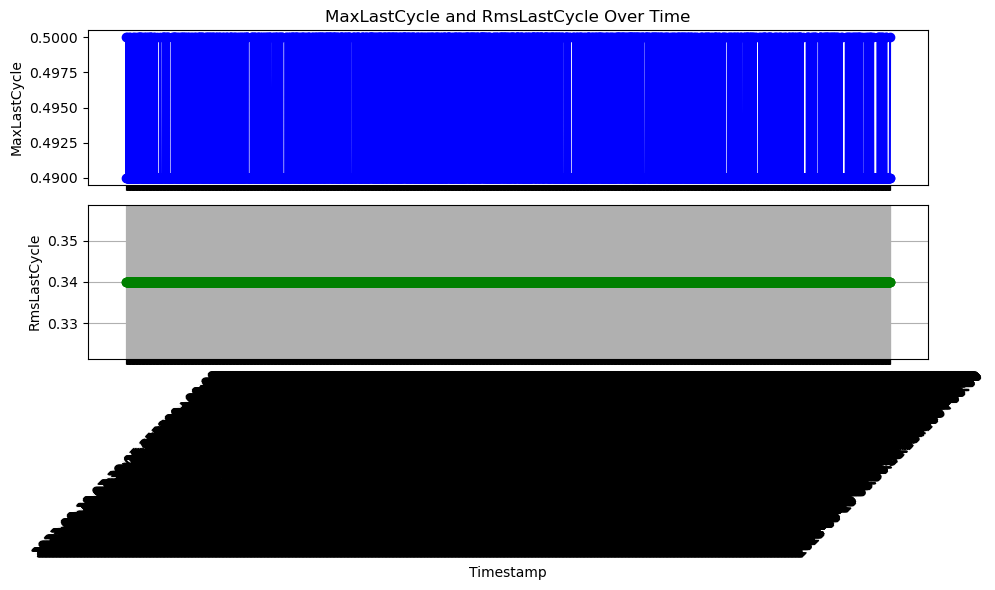

In [31]:
# Create a new figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 'MaxLastCycle' in the first subplot (ax1)
ax1.plot(df_plc_1_hour_no_na['_time'], df_plc_1_hour_no_na['MaxLastCycle'], marker='o', linestyle='-', color='b')
ax1.set_ylabel('MaxLastCycle')
ax1.set_title('MaxLastCycle and RmsLastCycle Over Time')

# Plot 'RmsLastCycle' in the second subplot (ax2)
ax2.plot(df_plc_1_hour_no_na['_time'], df_plc_1_hour_no_na['RmsLastCycle'], marker='o', linestyle='-', color='g')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('RmsLastCycle')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

### EDA sensor_raw 15m

In [69]:
df_sensor_raw = pd.read_csv('sensor_raw_15m.csv')

In [85]:
df_sensor_raw.head()

,result,table,_start,_stop,_time,_value,Device Type,Key Values,Manufacturer,_field,_measurement,article_no,measuring_time,rotation,sensor,serial_no
0,_result,0,2023-09-19 17:40:29.892865+00:00,2023-09-19 17:45:29.892865+00:00,2023-09-19 17:41:24+00:00,42.127072,Indexer,NaN,WEISS,temp,temperature,TC150T,0.54075,NaN,NaN,TC150T
1,_result,1,2023-09-19 17:40:29.892865+00:00,2023-09-19 17:45:29.892865+00:00,2023-09-19 17:43:17+00:00,41.906077,Indexer,NaN,WEISS,temp,temperature,TC150T,0.54125,NaN,NaN,TC150T
2,_result,2,2023-09-19 17:40:29.892865+00:00,2023-09-19 17:45:29.892865+00:00,2023-09-19 17:44:22+00:00,42.016575,Indexer,NaN,WEISS,temp,temperature,TC150T,0.54150,NaN,NaN,TC150T
3,_result,3,2023-09-19 17:40:29.892865+00:00,2023-09-19 17:45:29.892865+00:00,2023-09-19 17:42:12+00:00,41.795580,Indexer,NaN,WEISS,temp,temperature,TC150T,0.54175,NaN,NaN,TC150T
4,_result,4,2023-09-19 17:40:29.892865+00:00,2023-09-19 17:45:29.892865+00:00,2023-09-19 17:43:34+00:00,42.127072,Indexer,NaN,WEISS,temp,temperature,TC150T,0.54200,NaN,NaN,TC150T


In [ ]:
# drop unnecessary columns


In [83]:
unique_values = df_sensor_raw["Manufacturer"].value_counts()
unique_values

WEISS    4958
Name: Manufacturer, dtype: int64

In [ ]:
value_counts = df_sensor_raw['Key Values'].value_counts()

# Print or do whatever you need with the value counts
print(value_counts)

In [ ]:
df_sensor_raw.shape